# W.1. Equity Risk Analytics

## FINM 25000

### UChicago Financial Mathematics

#### Summer 2024

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

from sklearn.linear_model import LinearRegression
import sys
sys.path.insert(0,'../cmds')
from portfolio import *
from risk import *

In [2]:
LOADFILE = '../data/risk_etf_data.xlsx'
info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('ticker')
rets = pd.read_excel(LOADFILE,sheet_name='total returns').set_index('Date')
prices = pd.read_excel(LOADFILE,sheet_name='prices').set_index('Date')

FREQ = 252

$$\newcommand{\E}{E}$$
$$\newcommand{\rbar}{\bar{r}}$$
$$\newcommand{\rvec}{\boldsymbol{r}}$$
$$\newcommand{\rvecbar}{\boldsymbol{\bar{r}}}$$

$$\newcommand{\Ntime}{N}$$
$$\newcommand{\Nt}{N}$$

$$\newcommand{\rmat}{\boldsymbol{R}}$$

$$\newcommand{\riskmeasure}{\varrho}$$

$$\newcommand{\wt}{w}$$

$$\newcommand{\Nassets}{K}$$

$$\newcommand{\muvec}{\boldsymbol{\mu}}$$

$$\newcommand{\onevecNt}{\boldsymbol{1}_{\Ntime\times 1}}$$

$$\newcommand{\covest}{\hat{\boldsymbol{\Sigma}}}$$

$$\newcommand{\meanest}{\hat{\mu}}$$

$$\newcommand{\meanestvec}{\hat{\boldsymbol{\mu}}}$$

$$\newcommand{\covmat}{\boldsymbol{\Sigma}}$$

$$\newcommand{\rf}{r_f}$$

# Risk

### Volatility or More?

What is meant by **risk**?

May be associated with
* loss
* volatility
* correlation
* worst outcomes
* sensitivity

Various risk measures try to give information on all these.

### Return, Price, PnL, Other?

Our discussion of risk will be general to any asset class.
* Examples are across various assets.

The object of analysis will depend on the asset class:
* bonds and options: price
* equities, futures, and currency: return

At times, it will make sense to examine profit and loss (PnL).

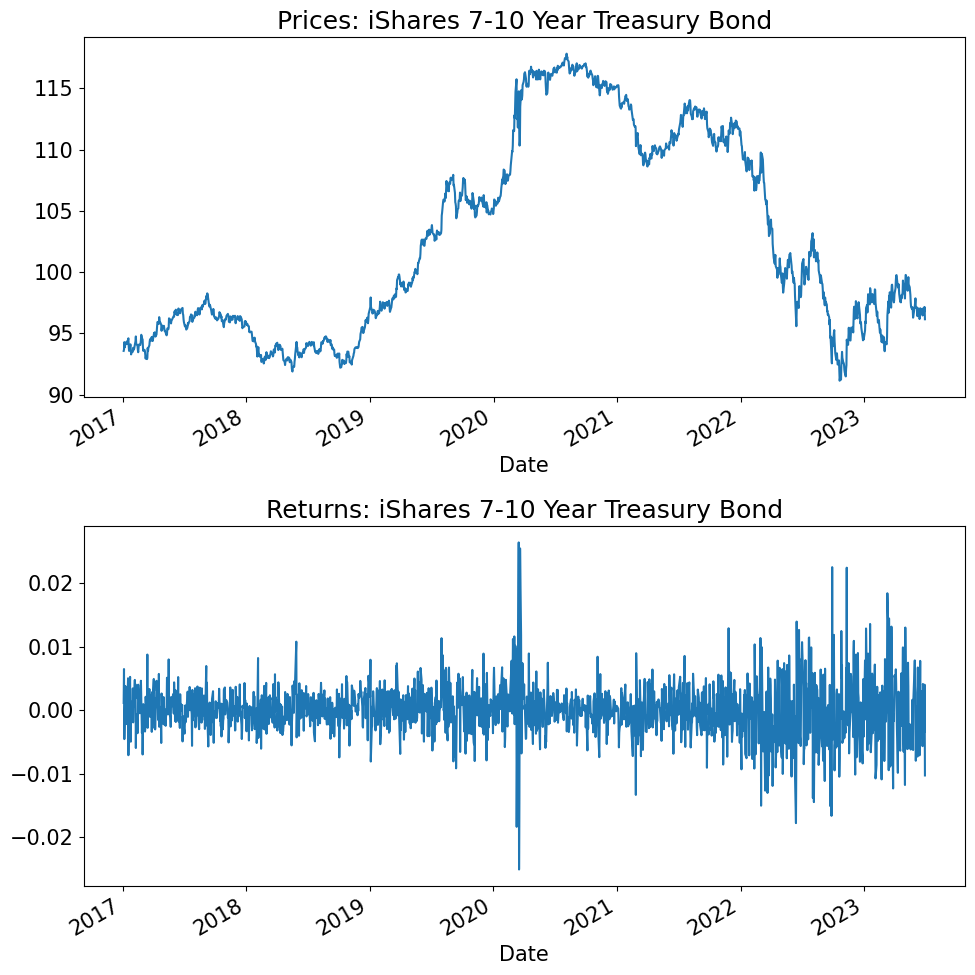

In [3]:
TICK = 'IEF'
fig, ax = plt.subplots(2,1,figsize=(10,10))
desc = info.loc[TICK,'shortName']
prices[TICK].plot(ax=ax[0],title=f'Prices: {desc}')
rets[TICK].plot(ax=ax[1],title=f'Returns: {desc}')
plt.tight_layout()
plt.show()

### Tools

The **tools** used are different than fixed income and options pricing. Relatively
* more statistics
* less math

For **bonds and options**, we saw risk via
* mathematical sensitivity of prices

For **equities** and other assets, we will be using
* statistical sensitivity of returns (or scaled prices)

### Model Approach
The modeling approach will rely on formulating the data such that it is
* stationary
    - Nearly always
    - This is often the motive for switching between prices, profits, returns, etc.

* iid (indepently and identically distributed)
    - Much of the complication is achieving this.

* normally distributed?
    - Rarely required.
    - A useful comparison.
    - At times a simplfiying approximation

### Note: Difference to Pricing

Risk uses different tools than pricing.
* No alternative **probability measures**.
* **Volatility** will mean actual variation, not options pricing quotes.
* Mostly use discrete-time models, not continuous-time stochastic calculus.

## Starting Point

Question:
* Is a 10-year Treasury Note risky?

To start, we consider risk over a single given period.
* This is not just pedagogical
* Risk managers will mostly focus on risk over the next period.
* Delta, duration are good examples of this

For some problems, we will need to consider 
* multiple-period risk
* cumulative returns

# Moments

## Data

As an example for analyzing risk, we consider 
* ETF data on various asset classes
* daily frequency
* 2017 through present

The ETF data ensures
* we are looking at traded security returns, not indexes
* thus, no issue of rolling futures, carry on FX, etc.
* Though there may be differences due to fund expenses and fund tracking error (oil?)

In [4]:
info

,quoteType,shortName,volume,totalAssets,longBusinessSummary
ticker,,,,,
SPY,ETF,SPDR S&P 500,3695818,4.227204e+11,The Trust seeks to achieve its investment obje...
VEA,ETF,Vanguard FTSE Developed Markets,293687,1.680537e+11,The fund employs an indexing investment approa...
UPRO,ETF,ProShares UltraPro S&P 500,433011,2.758412e+09,The fund invests in financial instruments that...
GLD,ETF,SPDR Gold Trust,577948,5.666016e+10,The Trust holds gold bars and from time to tim...
USO,ETF,United States Oil Fund,142872,1.516177e+09,USO invests primarily in futures contracts for...
CL=F,FUTURE,Crude Oil Sep 23,88194,NaN,NaN
FXE,ETF,Invesco CurrencyShares Euro Cur,1019,2.520237e+08,NaN
BTC-USD,CRYPTOCURRENCY,Bitcoin USD,13960983552,NaN,NaN
HYG,ETF,iShares iBoxx $ High Yield Corp,1387739,1.456480e+10,The underlying index is a rules-based index co...


## Mean

The mean is the **first moment** of the (unspecified) distribution:
$$ \mu = \E[r]$$

The sample estimator for it is
$$\meanest = \frac{1}{\Ntime}\sum_{t=1}^\Ntime r_t$$

Note that this is often expressed with "bar" notation, $\bar{r}$.
* Here the notation is $\hat{\mu}$ for symmetry with many estimators below using "hat" notation.

### Important for risk?
For measuring and analyzing risk, we will mostly consider **de-meaned** data. 
* We want to know the possible outcomes **relative** to the mean.
* Interesting models of the mean are more useful for forecasting returns for directional investing.

#### Note
* Having an incorrect measure of the mean will cause error in our relative assessments.
* However, the main focus will be risk over short periods, for which the mean (trend) will not matter much to the calculation.

### Data: Means

The mean ETF data is listed below for price an return.

#### Technical Note
* Does it make sense to analyze this for price and return?
* That is, do they both satisfy basic statistical properties to be well-suited to examining unconditional moments?

In [5]:
pd.concat([prices.mean(),rets.mean()*FREQ],axis=1,keys=['price','return']).style.format({'price':'{:.2f}','return':'{:.2%}'})

,price,return
SPY,318.28,13.92%
VEA,39.63,7.94%
UPRO,33.03,36.52%
GLD,148.31,8.24%
USO,73.73,2.87%
CL1,63.34,-40.90%
FXE,106.39,0.27%
BTC,18236.20,80.42%
HYG,70.86,3.06%
IEF,102.58,0.65%


## Variance and Volatility (StdDev)

The variance is the **second centered moment** of the (unspecified) distribution.
$$\sigma^2 = \E\left[(r-\mu)^2\right]$$

The usual sample estimator for the variance is
$$\hat{\sigma}^2 = \frac{1}{\Ntime-1}\sum_{t=1}^\Ntime(r_t-\meanest)^2$$ 

#### Question
Note that though there are $\Ntime$ data points in the sample, the estimator for the variance uses $\Ntime-1$.

What is the reason? 
* statistically
* conceptually

### Standard Deviation

The standard deviation (in population and in sample) is the square root of the formulas above.
* We will often refer to this as the **volatility**.
* One could make the distinction of volatility as the time-varying (instantaneous) standard deviation of the process, but more often it is used synonomously with standard deviation.

### Technical Points
#### Non-negativity
The standard deviation is defined in such a way that it is **always non-negative**.
* Thus, models of volatility (realized: GARCH, implied: SABR) have to be careful to ensure this holds.

#### Centering
The variance is the second **squared** moment. Note that inside the expectation is $r-\mu$.

The second (uncentered) moment is $\E\left[r^2\right]$, and it is sometimes useful to have the variance as the difference of the (uncentered) first and second moments:

$$\sigma^2 = \E\left[r^2\right] - \left(\E[r]\right)^2$$

In [6]:
vol = (rets.std().to_frame('vol')*np.sqrt(FREQ))
vol['variance'] = vol['vol']**2
vol.style.format('{:.2%}')

,vol,variance
SPY,19.51%,3.81%
VEA,18.20%,3.31%
UPRO,58.89%,34.68%
GLD,13.79%,1.90%
USO,40.96%,16.78%
CL1,139.29%,194.03%
FXE,7.38%,0.54%
BTC,74.95%,56.17%
HYG,9.38%,0.88%
IEF,6.75%,0.46%


## Higher Moments

### Skewness

Skewness is the **third  moment** (centered and scaled). 

$$\varsigma = \frac{1}{\sigma^3}\E\left[(r-\mu)^3\right]$$

The sample estimator is

$$\hat{\varsigma} = \frac{1}{\hat{\sigma}^3} \frac{1}{\Ntime-1}\sum_{t=1}^\Ntime(r_t-\meanest)^3$$

Note that the skewness
* can be positive or negative
* is NOT typically listed as a percentage

The skewness is negative for distributions where there is an asymmetric, "long left tail".

### Kurtosis

Kurtosis is the **fourth  moment** (centered and scaled). 

$$\kappa = \frac{1}{\sigma^4}\E\left[(r-\mu)^4\right]$$

The sample estimator is

$$\hat{\kappa} = \frac{1}{\hat{\sigma}^4} \frac{1}{\Ntime-1}\sum_{i=1}^\Ntime(r_t-\meanest)^4$$

Note that the kurtosis
* is non-negative
* is NOT typically listed as a percentage

Furthermore, kurtosis is typically expressed **excess kurtosis**, $\kappa - 3$.
* This is to compare it to the normal distribution, which has kurtosis of 3.

The skewness is negative for distributions where there is an asymmetric, "long left tail".

In [7]:
get_moments(rets,FREQ)

,mean,vol,skewness,kurtosis
SPY,13.92%,19.51%,-0.57,12.55
VEA,7.94%,18.20%,-1.04,16.41
UPRO,36.52%,58.89%,-0.56,14.21
GLD,8.24%,13.79%,-0.22,3.39
USO,2.87%,40.96%,-1.36,16.50
CL1,-40.90%,139.29%,-27.75,931.85
FXE,0.27%,7.38%,0.06,1.03
BTC,80.42%,74.95%,-0.03,5.69
HYG,3.06%,9.38%,0.12,24.73
IEF,0.65%,6.75%,0.25,4.38


### Annualizing the Moments

To annualize the moments use the frequency, of data per year, $\tau$,

|            | annualize     | sign  | quote  |
|------------|---------------|-------|--------|
| mean       | $\tau$        | + / - | %      |
| volatility | $\sqrt{\tau}$ | +     | %      |
| skewness   | 1             | + / - | number |
| kurtosis   | 1             | +     | number |

For instance, to annualize (trading) 
* daily data, $\tau=252$.
* monthly data, $\tau=12$.

# Distribution

## Quantiles

The risk measures based on "moments" make use of data in the entire distribution.
* This allows for high statistical power.
* Those moments make **no assumption about the distribution.**

The **quantiles** 
* continue without any assumption on the distribution.

But they are estimating a single point on the distribution.
* This means it gets less precision from the sample.

If the variable has a distribution with a continuous and strictly increasing cdf, denoted $F$, with an inverse cdf of $F^{-1}$. Then the quantile $\pi$ is
$$q_{\pi} = F^{-1}(\pi)$$

The sample estimate is the **order statistic**.
* Sort the sample into ascending order.
* Define the sorted data as $\{r_{(1)},\ldots,r_{(\Ntime)}\}$.

$$\hat{q}_{\pi} = r_{(\pi \Ntime)}$$

### Median
Of course, for $\pi=0.5$, this is the median:
$$\hat{q}_{0.5} = r_{\text{median}}$$

#### Technical Note
If $\pi\Ntime$ is not an integer, typical to take a linear interpretation between the nearest two ordered points.
$$\hat{q}_{\pi} = \frac{r_{(\pi \Ntime-)} + r_{(\pi \Ntime+)}}{2}$$

In [8]:
quantiles = rets.quantile(q=[.01,.05,.25,.5,.75,.95,.99])
quantiles.index.name = 'quantile'

quantiles.reset_index(inplace=True)
quantiles['quantile'] = quantiles['quantile'].astype(str)
quantiles.set_index('quantile',inplace=True)
quantiles.style.format('{:.2%}')

,SPY,VEA,UPRO,GLD,USO,CL1,FXE,BTC,HYG,IEF,TIP,SHV
quantile,,,,,,,,,,,,
0.01,-3.43%,-3.03%,-10.34%,-2.22%,-7.23%,-7.96%,-1.12%,-12.92%,-1.63%,-1.08%,-1.09%,-0.04%
0.05,-1.85%,-1.60%,-5.65%,-1.40%,-3.74%,-4.02%,-0.74%,-6.73%,-0.77%,-0.65%,-0.53%,-0.02%
0.25,-0.38%,-0.48%,-1.14%,-0.44%,-1.10%,-1.18%,-0.29%,-1.73%,-0.17%,-0.23%,-0.17%,0.00%
0.5,0.07%,0.09%,0.20%,0.06%,0.16%,0.24%,0.01%,0.20%,0.02%,0.00%,0.02%,0.00%
0.75,0.63%,0.59%,1.85%,0.49%,1.32%,1.40%,0.29%,2.34%,0.21%,0.23%,0.19%,0.01%
0.95,1.65%,1.56%,4.90%,1.42%,3.30%,3.56%,0.76%,7.96%,0.76%,0.66%,0.55%,0.04%
0.99,3.05%,2.82%,9.17%,2.27%,5.72%,7.33%,1.14%,13.83%,1.53%,1.18%,1.22%,0.05%


## Normal Distribution

**NONE** of the measures discussed above rely on a normal distribution.

But later we will consider estimates that rely on an assumed distribution, and whether returns are normal.

So how good of an approximation is a normal distribution?

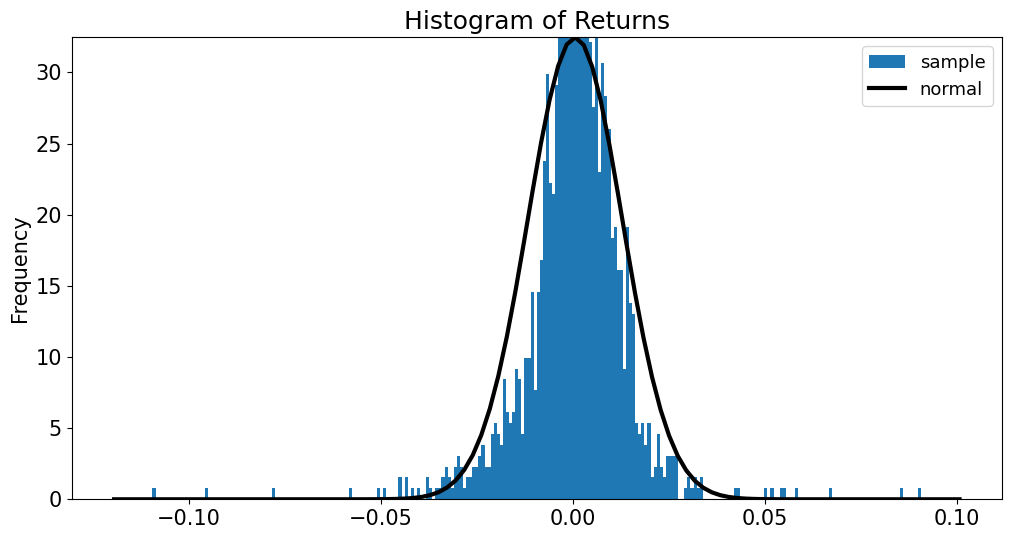

In [9]:
data = rets['SPY']
fig = plot_normal_histogram(data,bins=250);
plt.title('Histogram of Returns');
plt.show()

### Outliers

The histogram doesn't look too far off at first glance.

But consider the outliers.
* A normal distribution implies 5 and 10 std.dev. outliers almost never happen.
* In the sample above, there are numerous.

#### Outlier Table
* The outlier table below shows z-scores for the min and max return.
* The final two columns show the probability of such values happening under a normal distribution.

In [10]:
outlier_normal(rets).set_caption('Daily')

,z min,z max,normal prob min,normal prob max
SPY,-8.95,7.33,1.81e-19,1.18e-13
VEA,-9.78,7.73,6.83e-23,5.33e-15
UPRO,-9.46,7.50,1.55e-21,3.21e-14
GLD,-6.22,5.55,2.54e-10,1.45e-08
USO,-9.81,6.45,4.88e-23,5.44e-11
CL1,-34.85,4.31,2.08e-266,8.14e-06
FXE,-4.42,4.56,4.85e-06,2.51e-06
BTC,-7.94,5.28,1.01e-15,6.45e-08
HYG,-9.32,11.05,5.87e-21,0.00e+00
IEF,-5.90,6.21,1.77e-09,2.68e-10


#### Astronomical

The probabilities are astronomical.
* Clearly the returns are not normally distributed--particularly for tail events.

Ironically, this means that a normal distribution as a rough approximation might be fine--except for the events we care most about in managing risk--big outliers.

### Time Frequency

However, consider that the normality may depend on the frequency of the data.
* At finer granularity, (daily, intra-daily,) perhaps the aberrations are stronger.
* At a less frequent time interval, perhaps these compound and average out.

#### Monthly returns
The table below repeats the example for monthly returns.

In [11]:
retsM = prices.resample('M').last().pct_change()
outlier_normal(retsM).set_caption('Monthly')

,z min,z max,normal prob min,normal prob max
SPY,-2.80,2.38,2.54e-03,8.56e-03
VEA,-3.25,2.82,5.75e-04,2.37e-03
UPRO,-3.38,2.28,3.68e-04,1.12e-02
GLD,-2.06,2.69,1.99e-02,3.59e-03
USO,-4.49,2.80,3.58e-06,2.54e-03
CL1,-3.71,5.80,1.03e-04,3.33e-09
FXE,-2.36,2.65,9.21e-03,4.04e-03
BTC,-1.80,2.61,3.62e-02,4.58e-03
HYG,-4.19,2.63,1.38e-05,4.21e-03
IEF,-2.52,2.06,5.84e-03,1.99e-02


# Maximum Drawdown

The maximum drawdown (MDD) of a return series is the maximum cumulative loss suffered during the time period.
* Visually, this is the largest peak-to-trough during the sample.
* It is widely cited in performance evaluation to understand how badly the investment might perform.

#### Technical Note

Maximum drawdown is widely cited in backtests.
* This can be quite useful in understanding the scale / nature of the strategy, especially how it performs in certain scenarios.
* It is less useful than the "moment" statistics above in forecasting the future.
* It is a path-dependent statistic, and it has much less statistical precision.

## Example

Consider the price chart below.
* MDD is the largest peak-to-valley point of the graph.
* This is not always easy to see from the price graph.

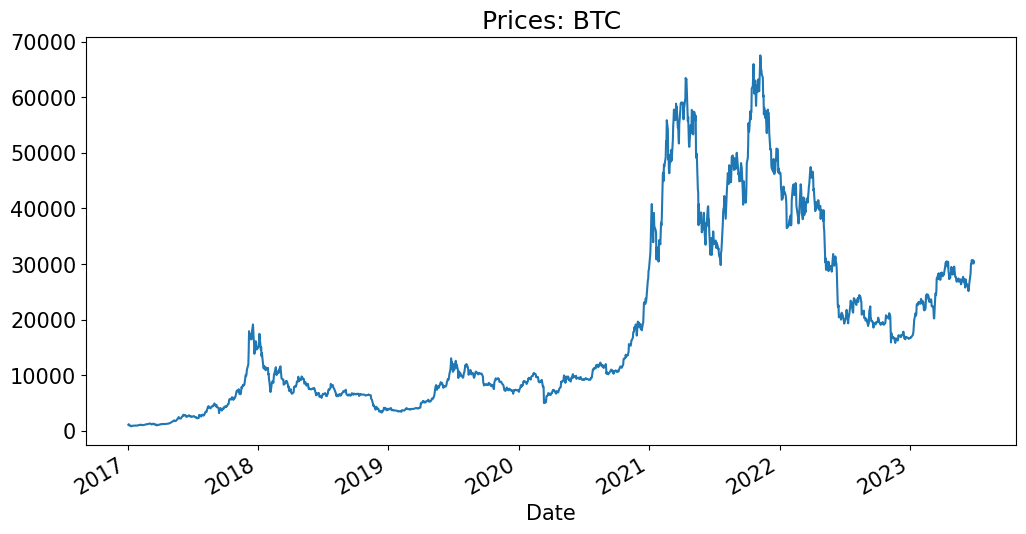

In [12]:
TICK = 'BTC'
prices[TICK].plot(title=f'Prices: {TICK}');

#### Consider a MDD chart
* For any point in time, it shows how far the strategy is below its max up to that point.
* Whenever it is at 0, the strategy is at a current maximum.

In [13]:
def mdd_timeseries(rets):
    cum_rets = (1 + rets).cumprod()
    rolling_max = cum_rets.cummax()
    drawdown = (cum_rets - rolling_max) / rolling_max
    return drawdown

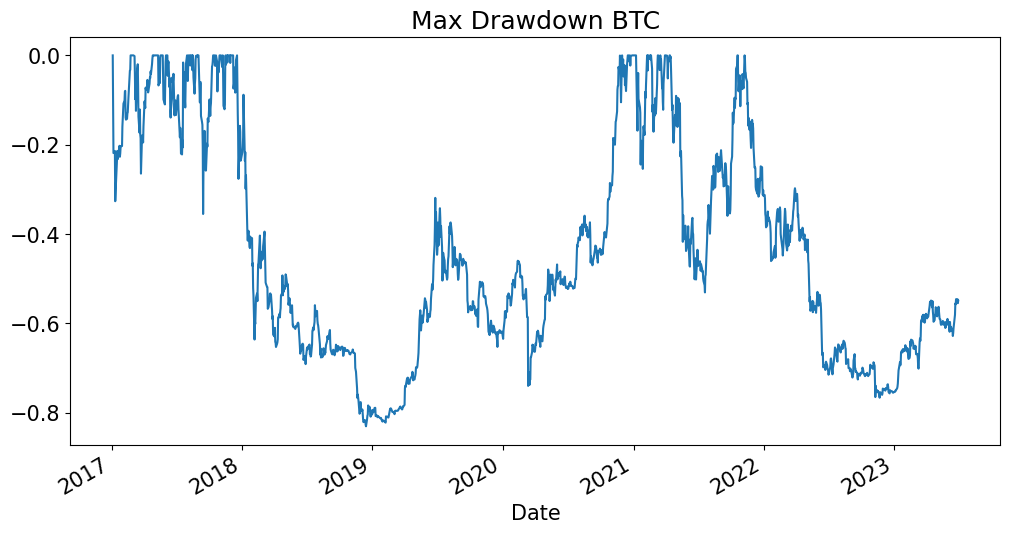

In [14]:
drawdown = mdd_timeseries(rets)
drawdown[TICK].plot(title=f'Max Drawdown {TICK}');
plt.show()

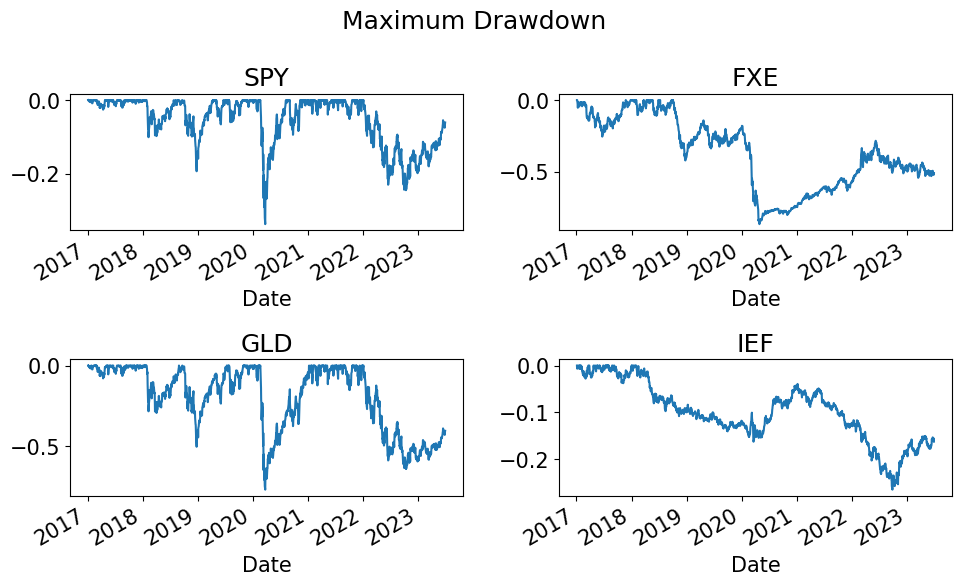

In [15]:
fig, ax = plt.subplots(2,2,figsize=(10,6))
for i in range(4):
    lab = drawdown.columns[i*3]
    drawdown.iloc[:,2*i].plot(ax=ax[i%2,int(np.floor(i/2))],title=lab)

plt.suptitle('Maximum Drawdown')
plt.tight_layout()
plt.show()

In [16]:
maximumDrawdown(rets).style.format({'Skewness':'{:.2f}','Kurtosis':'{:.2f}','Max Drawdown':'{:.2%}','Peak':'{:%Y-%m-%d}', 'Bottom':'{:%Y-%m-%d}'})

,Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
SPY,-33.72%,2020-02-19,2020-03-23,2020-08-10 00:00:00,173 days 00:00:00
VEA,-35.74%,2018-01-26,2020-03-23,2020-11-16 00:00:00,1025 days 00:00:00
UPRO,-76.82%,2020-02-19,2020-03-23,2021-01-08 00:00:00,324 days 00:00:00
GLD,-22.00%,2020-08-06,2022-09-26,NaT,NaT
USO,-86.75%,2018-10-03,2020-04-28,NaT,NaT
CL1,-149.25%,2018-10-03,2020-04-20,2021-10-04 00:00:00,1097 days 00:00:00
FXE,-26.46%,2018-02-01,2022-09-27,NaT,NaT
BTC,-83.04%,2017-12-18,2018-12-14,2020-11-30 00:00:00,1078 days 00:00:00
HYG,-22.03%,2020-02-13,2020-03-23,2020-11-04 00:00:00,265 days 00:00:00
IEF,-22.65%,2020-08-04,2022-10-20,NaT,NaT


# Multivariable Risk

All the risk measures above are **univariate**.
* The measures above for a return $r$ depend only on functions of the distribution (sample) of $r$.

We will need to consider **multivariable measures**.
* As we will see, the risk for a portfolio will require these measures.

### Notation
Consider a return on asset $i$ and $j$, denoted as $r_i$ and $r_j$.
* Note that these superscripts are not exponents but rather identifiers.

## Covariance

The covariance is defined as

$$\sigma_{i,j} = \E\left[(r_{i,t}-\mu_i)(r_{j,t}-\mu_j)\right]$$

* A covariance of a variable with itself is the variance.

The sample estimate of the covariance is

$$\hat{\sigma}_{i,j} = \frac{1}{\Ntime}\sum_{t=1}^\Ntime\left(r_{i,t} - \meanest_i\right)\left(r_{j,t} - \meanest_j\right)$$

#### Covariance Matrix

For $\Nassets$ assets, it is easier to use matrix notation to write the coviariance $\sigma_{i,j}$ as the $i$ row and $j$ column of the $\Nassets\times \Nassets$ **covariance matrix**.
* Note that the diagonal of the matrix is the set of asset variances, $\sigma_{j,j}=\sigma^2_j$.

Let $\rmat$ denote the $\Ntime\times \Nassets$ matrix of sample returns.
* Each of $\Ntime$ rows is a sample observation (period of time).
* Each of $\Nassets$ columns is an asset return.

Perhaps somewhat confusingly, it is common to denote this covariance matrix using the capital Greek letter, $\Sigma$. This looks like a summation sign, but it denotes the $\Nassets\times \Nassets$ covariance:

$$\covmat = \E\left[(\rvec-\muvec)(\rvec-\muvec)'\right]$$

The sample estimator is the $\Nassets\times\Nassets$ matrix,
$$\covest = (\rmat-\meanestvec)(\rmat-\meanestvec)'\left(\frac{1}{\Ntime-\Nassets}\right)$$

where $\meanest$ denotes the $\Nassets\times 1$ vector of sample averages:

$$\meanestvec = \rmat'\onevecNt \left(\frac{1}{\Ntime}\right)$$

and where $\onevecNt$ denotes the $\Ntime\times 1$ vector of ones.

#### Technical Note: Properties of the Covariance Matrix
The covariance matrix is
* symmetric: $\Nassets(\Nassets+1)/2$ unique elements
* positive (semi) definite

Positive definite
* does **not** mean each element of the matrix, $\sigma_{i,j}$ is positive
* it means that any combination of the assets will have non-negative variance.

Mathematically, for any $\Nassets\times 1$ $w$, 
$$w'\covest w\ge 0$$

In [17]:
rets.cov().style.format('{:.4%}')

,SPY,VEA,UPRO,GLD,USO,CL1,FXE,BTC,HYG,IEF,TIP,SHV
SPY,0.0151%,0.0124%,0.0456%,0.0008%,0.0102%,0.0151%,0.0010%,0.0141%,0.0058%,-0.0010%,0.0002%,-0.0000%
VEA,0.0124%,0.0131%,0.0375%,0.0018%,0.0102%,0.0140%,0.0020%,0.0139%,0.0052%,-0.0008%,0.0004%,-0.0000%
UPRO,0.0456%,0.0375%,0.1376%,0.0025%,0.0306%,0.0453%,0.0029%,0.0425%,0.0174%,-0.0030%,0.0004%,-0.0001%
GLD,0.0008%,0.0018%,0.0025%,0.0076%,0.0017%,0.0017%,0.0017%,0.0046%,0.0009%,0.0015%,0.0015%,0.0000%
USO,0.0102%,0.0102%,0.0306%,0.0017%,0.0666%,0.1057%,0.0003%,0.0089%,0.0043%,-0.0017%,0.0013%,-0.0001%
CL1,0.0151%,0.0140%,0.0453%,0.0017%,0.1057%,0.7700%,0.0004%,0.0184%,0.0082%,-0.0022%,0.0020%,-0.0001%
FXE,0.0010%,0.0020%,0.0029%,0.0017%,0.0003%,0.0004%,0.0022%,0.0022%,0.0007%,0.0004%,0.0003%,0.0000%
BTC,0.0141%,0.0139%,0.0425%,0.0046%,0.0089%,0.0184%,0.0022%,0.2229%,0.0055%,-0.0000%,0.0013%,-0.0000%
HYG,0.0058%,0.0052%,0.0174%,0.0009%,0.0043%,0.0082%,0.0007%,0.0055%,0.0035%,0.0001%,0.0005%,0.0000%
IEF,-0.0010%,-0.0008%,-0.0030%,0.0015%,-0.0017%,-0.0022%,0.0004%,-0.0000%,0.0001%,0.0018%,0.0012%,0.0000%


## Correlation

The scale of the covariance matrix makes it harder to interpret.

Consider the **correlation**, which rescales the covariance in a way that is much more useful for interpretation:
* between -1 and 1
* same sign as the covariance

$$\rho_{i,j} = \frac{\sigma_{i,j}}{\sigma_i\sigma_j}$$

Consider the matrix of correlations.
* will be positive semi-definite, as is the covariance matrix.

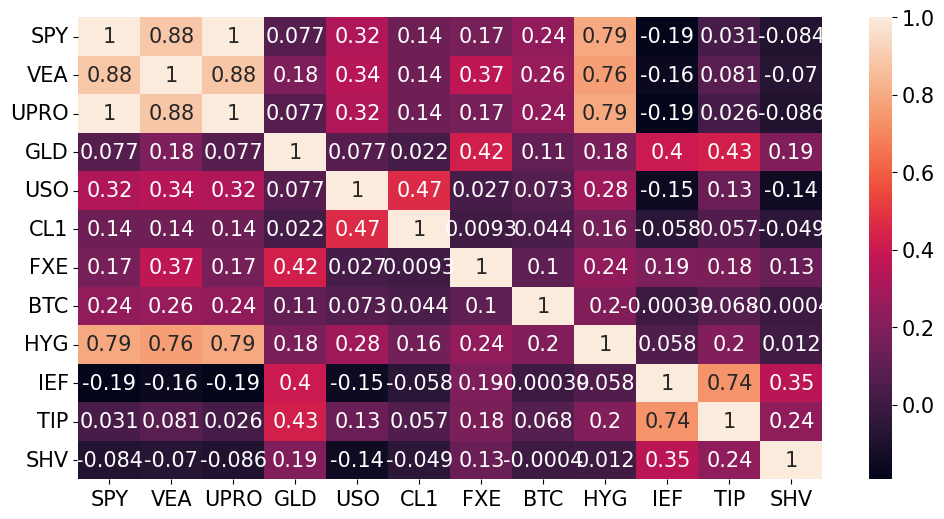

In [18]:
sns.heatmap(rets.corr(),annot=True);

## Beta

Consider a linear decomposition of $r_i$ on $r_j$:
$$r_{i,t} = \alpha + \beta r_{j,t} + \epsilon_t$$

The OLS sample estimator of $\beta$ is
$$\begin{bmatrix}\hat{\alpha}\\ \hat{\beta}\end{bmatrix} = (\rmat_j'\rmat_j)^{-1}\rmat_j'\rvec_i$$

where $\rmat_j$ denotes the $N\times 2$ matrix where the first column is a vector of ones and the second column is the vector of sample returns of $r_{j,t}$ for $1\le t\le \Ntime$.


### Scaled correlation
Equivalently, for a single-variable regression, the **beta is simply a scaled correlation**:

$$\beta = \frac{\sigma_i}{\sigma_j}\rho_{i,j}$$

The sample estimator is then the product of the sample estimates of these standard deviations and the correlation.

Thus, for bivariate measures, 
#### Covariance, correlation, and beta are just three ways of scaling the relationship

In [19]:
COMP = 'SPY'
birisk = pd.DataFrame(dtype=float, columns=['corr','cov','beta'], index=rets.columns)
birisk['corr'] = rets.corr()[COMP]
birisk['cov'] = rets.cov()[COMP] * FREQ
for sec in rets.columns:
    birisk.loc[sec,'beta'] = LinearRegression().fit(rets[[COMP]],rets[[sec]]).coef_[0]

birisk.columns = [f'{COMP} {col}' for col in birisk.columns]
birisk.style.format({birisk.columns[0]:'{:.2%}',birisk.columns[1]:'{:.4%}',birisk.columns[2]:'{:.4f}'})

,SPY corr,SPY cov,SPY beta
SPY,100.00%,3.8065%,1.0000
VEA,88.36%,3.1370%,0.8241
UPRO,99.92%,11.4802%,3.0160
GLD,7.69%,0.2071%,0.0544
USO,32.19%,2.5725%,0.6758
CL1,14.01%,3.8076%,1.0003
FXE,17.04%,0.2454%,0.0645
BTC,24.24%,3.5451%,0.9313
HYG,79.38%,1.4534%,0.3818
IEF,-18.82%,-0.2477%,-0.0651


## Multivariate Beta

Beta as a rescaled correlation is helpful, but regression betas can be much more.

Consider a multivariate regression:

$$r_{i,t} = \alpha + \beta_j r_{j,t} +\beta_k r_{k,t} + \epsilon_t$$

The OLS sample estimator of $\beta$ is
$$\begin{bmatrix}\hat{\alpha}\\ \hat{\beta}_j\\ \hat{\beta}_k\end{bmatrix} = (\rmat'\rmat)^{-1}\rmat'\rvec_i$$

noting that here $\rmat$ denotes the matrix with columns of 
* ones, 
* $r_{j,t}$
* $r_{k,t}$

That is, each row is an observation, $t$, and each colmn is a variable, $(1, r_j, r_k)$.

In [20]:
COMPS = ['SPY','VEA']
betas = pd.DataFrame(dtype=float, columns=COMPS, index=rets.columns)
for sec in rets.columns:
    betas.loc[sec] = LinearRegression().fit(rets[COMPS],rets[[sec]]).coef_

betas.join(birisk['SPY beta']).rename(columns={'SPY beta': 'SPY (univariate)'}).style.format('{:.4f}')

,SPY,VEA,SPY (univariate)
SPY,1.0000,0.0000,1.0000
VEA,0.0000,1.0000,0.8241
UPRO,3.0161,-0.0002,3.0160
GLD,-0.2789,0.4044,0.0544
USO,0.1686,0.6155,0.6758
CL1,0.5627,0.5310,1.0003
FXE,-0.2686,0.4042,0.0645
BTC,0.2640,0.8097,0.9313
HYG,0.2602,0.1476,0.3818
IEF,-0.0702,0.0062,-0.0651


***

# Extra: Coherent Risk Measures

## Risk Measures

Do all these metrics have the properties which will make for a useful risk measure?

Define the following notation:
* two risky payoffs (in USD) $\Pi_j, \Pi_k$.
* $\alpha$: amount of cash holding.

A **risk measure** $\riskmeasure$ measures
* a dollar amount of losses--not the expected losses, but rather the amount of losses that could result
* equivalently, the amount of capital required to protect against losses

Different risk measures will give different answers to this question.
* volatility (std.dev.)
* variance
* quantile

If a risk measure of a risky position, $\riskmeasure(\Pi_j)$ is negative, it indicates an amount of capital that could be withdrawn.

### Risk Capital

The term **risk capital** is used at times to refer to this capital needed to protect against a measure of loss from the portfolio--whether explicitly a margin requirement or an internal budget.

In that sense, the risk measure is assigning the risk capital budgeted for each portfolio.

## Coherence

For a risk measure to be sensible for measuring risk capital, it should have certain features.

A **coherent** risk, $\riskmeasure$, measure satisfies the following properties:

### Translation Invariance

$$\riskmeasure(\alpha + \Pi_j) = \riskmeasure(\Pi_j)-\alpha$$

Adding cash to a position reduces the capital needed to support it one-for-one.

A stock plus cash needs less **additional** capital support (protection) than the stock alone.

If this were not true, it would say that, for risk purposes, combining the cash with the risky assets is different than holding the cash in a separate account.

### Positive Homogeneity

For any positive scaling, $\lambda>0$,

$$\riskmeasure(\lambda\Pi_j) = \lambda\riskmeasure(\Pi_j)$$

The risk capital scales linearly with the position.
* This property is controversial in certain settings and for large scaling, $\lambda$.

### Monotonicity

If $\Pi_j>\Pi_k$ in every state (almost surely) then the risk measure of $\Pi_j$ is lower:

$$\riskmeasure\left(\Pi_j\right) < \riskmeasure\left(\Pi_k\right)$$

For instance, suppose that
* $\Pi_i$ is a stock
* $\Pi_j$ is the same stock plus a long put option

Then this definition requires that a **coherent** risk measure would assign lower risk to $\Pi_j$.

### Subadditive

The risk of the total is less than the sum of its parts:
$$\riskmeasure\left(\Pi_j + \Pi_k\right) \le \riskmeasure\left(\Pi_j\right) + \riskmeasure\left(\Pi_k\right)$$

This condition states that there is a diversification benefit, or at least, no harm.

#### Margin requirement
If this condition did not hold, it would say that there is a direct benefit to splitting assets across accounts, rather than having them net for the margin requirement.

### Convex Risk Measure

There is some use of a generalized concept, the **convex** risk measure. It replaces
* Homogeneity
* Subadditivity

with **convexity** which says that for any $\lambda\in[0,1]$,
$$\riskmeasure(\lambda\Pi_j + (1-\lambda)\Pi_k) \le \lambda\riskmeasure(\Pi_j) + (1-\lambda)\riskmeasure(\Pi_k)$$

### Questions

Which are **coherent** risk measures?
1. Standard deviation
2. Variance
3. 5th quantile of the loss distribution
4. Maximum Drawdown

In [21]:
keys = ['SPY','UPRO']

comp = pd.concat([rets[keys],rets[keys].sum(axis=1)],axis=1).rename(columns={0:'Portfolio'})

mdd = mdd_timeseries(comp)
QUANT = .05

tabcomp = pd.concat([comp.std(), comp.var(), comp.quantile(QUANT), mdd.min()],axis=1,keys=['std','variance',f'quantile {QUANT}','MDD'])
tabcomp.loc['sum of parts'] = tabcomp.iloc[0:-1,:].sum()
tabcomp.loc['sum of parts','variance'] = tabcomp.loc['sum of parts','std']**2
tabcomp.style.format('{:.4%}')

,std,variance,quantile 0.05,MDD
SPY,1.2290%,0.0151%,-1.8492%,-33.7172%
UPRO,3.7097%,0.1376%,-5.6467%,-76.8168%
Portfolio,4.9380%,0.2438%,-7.5018%,-87.7918%
sum of parts,4.9387%,0.2439%,-7.4958%,-110.5341%


# Dynamic Measures

Above, we measured these risks for a static situation. This would be sufficent for
* iid returns

For many cases of interest, we need the **conditional** risk measures.
* most notably, time-varying volatility

These conditional statistics may be measured with...
* a rolling window
* a stochastic volatility model (GARCH)
* simulation

# References

Coherent risk measures

https://people.math.ethz.ch/~delbaen/ftp/preprints/CoherentMF.pdf